In [233]:

file_path0 = "./UrbanSound8k/audio/fold1/50901-0-0-0.wav"
file_path1 = "./UrbanSound8k/audio/fold1/19026-1-0-0.wav"
file_path2 = "./UrbanSound8k/audio/fold1/15564-2-0-0.wav"
file_path3 = "./UrbanSound8k/audio/fold1/7383-3-0-0.wav"
file_path4 = "./UrbanSound8k/audio/fold1/14113-4-0-0.wav"
file_path5 = "./UrbanSound8k/audio/fold1/17592-5-0-0.wav"
file_path6 = "./UrbanSound8k/audio/fold1/7061-6-0-0.wav"
file_path7 = "./UrbanSound8k/audio/fold1/98223-7-0-0.wav"
file_path8 = "./UrbanSound8k/audio/fold1/30823-8-0-0.wav"
file_path9 = "./UrbanSound8k/audio/fold1/21684-9-0-5.wav"

In [358]:
import os #Allows for easy navigation within file directories 
from matplotlib import pyplot as plt #For data visualizations  
import tensorflow as tf #To build the deep learning model 
from tensorflow.keras import layers, models #to build complex CNN
import tensorflow_io as tfio #Efficient processing of audio clips
import IPython.display as ipd #to display wav file to listen to
import pandas as pd
import subprocess
import shutil
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import librosa
import librosa.display

## Problem Overview: Urban Sound Classification  

### Introduction  
Urban environments contain a wide variety of sounds, including traffic noise, human activities, and natural sounds. Identifying and classifying these sounds is valuable for applications such as noise pollution monitoring, smart city development, and assistive technology. The **UrbanSound8K** dataset provides labeled urban sound recordings, making it an ideal dataset for building a classification model.  I've chosen this product because during the coursework I have yet to work with sound files, so I felt it would be a great opportunity to learn the preprocessing and other nuances of modeling for audio.

### Problem Statement  
The goal of this project is to examine different preprocessing techniques and see how the affect the effectiveness of a simple CNN model.  The machine learning model will aim to accurately classify urban sounds from the **UrbanSound8K** dataset. The dataset contains **8,732 audio clips**, each labeled with one of **10 sound classes**, such as sirens, dog barking, drilling, and street music. Given an audio clip, the model should predict its corresponding sound category.

### Dataset Description  

#### **1. Audio Clips**  

##### **Format and Properties**  
- **Total clips:** 8,732  
- **File format:** WAV (`.wav`)  
- **Duration:** Each clip is **≤4 seconds** long  
- **Sampling rate:** 44.1 kHz  
- **Bit depth:** 16-bit PCM  
- **Mono audio:** Single-channel (mono) recordings  

##### **Sound Classes**  
Each clip is categorized into one of the following **10 classes**, which represent common urban sound events:  

| Class ID | Sound Category    | Description |  
|----------|------------------|-------------|  
| 0        | Air Conditioner  | Noise from air conditioning units |  
| 1        | Car Horn         | Honking sounds from vehicles |  
| 2        | Children Playing | Sounds of kids laughing, shouting, and playing |  
| 3        | Dog Bark         | Barking and yelping sounds from dogs |  
| 4        | Drilling         | Construction-related drilling noises |  
| 5        | Engine Idling    | Sounds of engines running without movement |  
| 6        | Gunshot          | Sharp, sudden gunfire sounds |  
| 7        | Jackhammer       | Continuous jackhammer operation noise |  
| 8        | Siren            | Emergency sirens from police, ambulances, or fire trucks |  
| 9        | Street Music     | Music played outdoors, including performances and busking |  

##### **Folder Structure**  
The dataset is organized into **10 folds**, numbered from `fold1` to `fold10`, for cross-validation. Each fold contains a subset of the dataset, enabling systematic training and testing splits.  

- Example file path:  
  ```
  UrbanSound8K/audio/fold1/147764-4-0-1.wav
  ```
  where:  
  - `147764` = ID of the original recording  
  - `4` = Class ID (Drilling)  
  - `0` = Start time of the sound in the original recording  
  - `1` = Clip number from the original recording  

#### **2. Metadata CSV File (`UrbanSound8K.csv`)**  

The dataset includes a CSV file named **`UrbanSound8K.csv`**, which contains metadata about all 8,732 audio clips. This file provides essential information for dataset processing and model training.  

##### **CSV File Structure**  
| Column Name  | Description | Example Value |  
|-------------|------------|--------------|  
| `slice_file_name` | Name of the audio clip file | `147764-4-0-1.wav` |  
| `fsID` | ID of the original field recording | `147764` |  
| `start` | Start time of the clip in the original recording (seconds) | `0` |  
| `end` | End time of the clip in the original recording (seconds) | `4` |  
| `salience` | Subjective measure of prominence (1 = foreground, 2 = background) | `1` |  
| `fold` | Fold number for cross-validation (1-10) | `4` |  
| `classID` | Numeric label for the sound category (0-9) | `4` |  
| `class` | Name of the sound category | `Drilling` |  

##### **Example Row from CSV**  
```
slice_file_name,fsID,start,end,salience,fold,classID,class
147764-4-0-1.wav,147764,0,4,1,4,4,Drilling
```
This entry represents a 4-second clip (`147764-4-0-1.wav`) from the original recording `147764`, labeled as **"Drilling" (Class ID = 4)**, and assigned to **fold 4** for cross-validation.

### **Challenges**  
- **Variability in Sound Quality** – The dataset includes recordings with different levels of background noise and varying quality.  
- **Overlapping Sounds** – Urban environments often feature multiple simultaneous sounds, making classification more difficult.  
- **Short Clip Durations** – Some clips are very short, limiting the amount of available information.  
- **Feature Extraction** – Raw audio must be converted into useful features (e.g., Mel-frequency cepstral coefficients, spectrograms) before classification.  


### Exploratory Data Analysis
While many of the audio clips had a sampling rate of 44100 Hz and 16-bit PCM, I first used FFmpeg to convert those that weren't to these specs.  This transformation allows easier fit with all preprocessing pipelines.  Histograms will be used to see correlation between categories of metadata.

But first, a visualization in the form of a waveform graph is displayed for a clip corresponding to each category of sound.  For audio clips of each, see the video presentation.

In [236]:
# Function to load audio files
def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate

waveform, sample_rate = load_audio(file_path0)
print('Waveform Tensor:', waveform)
print('Sample Rate:', sample_rate)

Waveform Tensor: tf.Tensor(
[-0.09078979 -0.07281494 -0.05941772 ...  0.0199585   0.03845215
  0.03604126], shape=(64000,), dtype=float32)
Sample Rate: tf.Tensor(16000, shape=(), dtype=int32)


In [237]:
def plot_audio(filename):
    waveform, sample_rate = load_audio(filename)

    plt.figure()
    plt.plot(waveform.numpy())

    return waveform, sample_rate

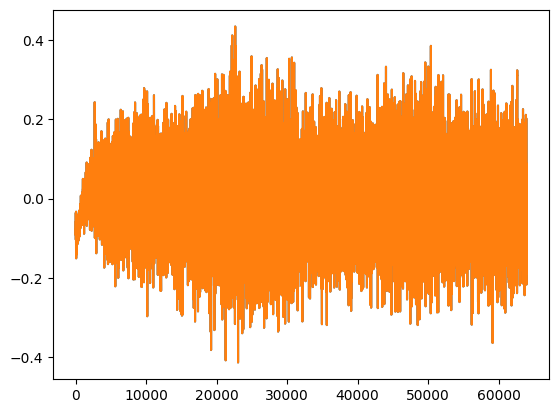

In [206]:
# Air Conditioner
waveformAC, sample_rate0 = plot_audio(file_path0)
plt.plot(waveformAC) 
plt.show()

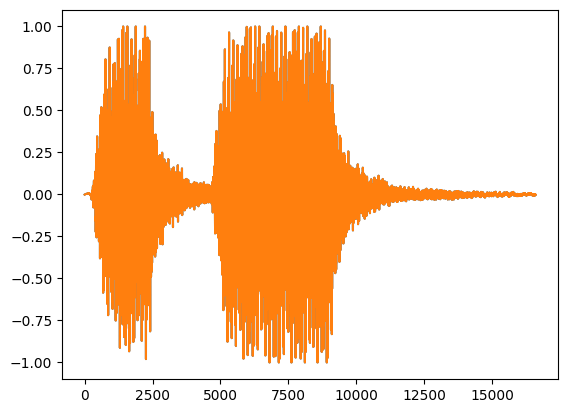

In [207]:
# Car Horn
waveform1, sample_rate1 = plot_audio(file_path1)
plt.plot(waveform1) 
plt.show()

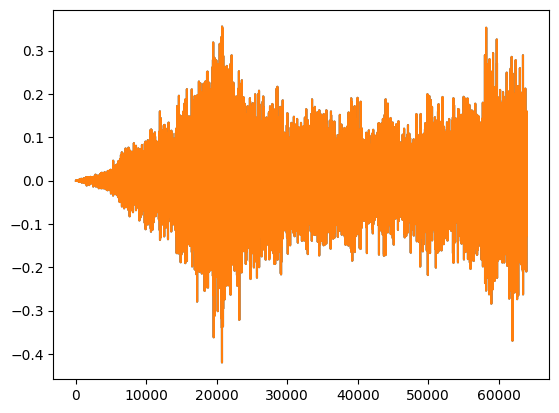

In [208]:
# Children Playing
waveform2, sample_rate2 = plot_audio(file_path2)
plt.plot(waveform2) 
plt.show()

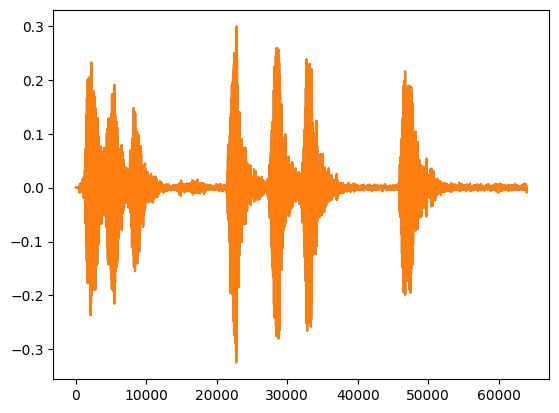

In [209]:
# Dog Bark
waveform3, sample_rate3 = plot_audio(file_path3)
plt.plot(waveform3) 
plt.show()

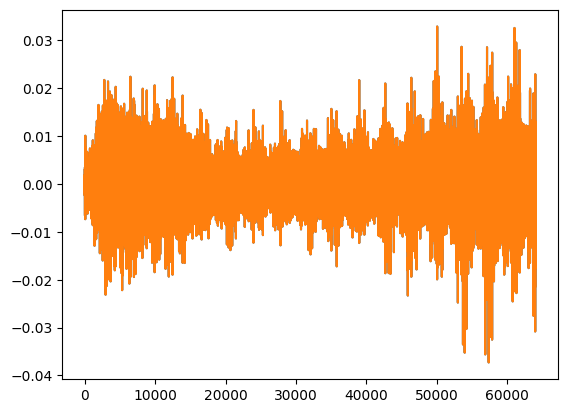

In [210]:
# Drilling
waveform4, sample_rate4 = plot_audio(file_path4)
plt.plot(waveform4) 
plt.show()

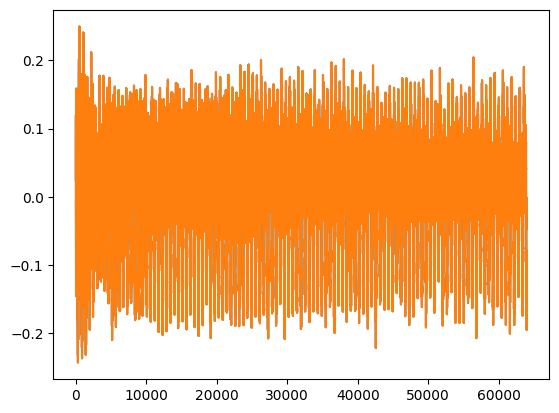

In [211]:
# Engine Idling
waveform5, sample_rate5 = plot_audio(file_path5)
plt.plot(waveform5) 
plt.show()

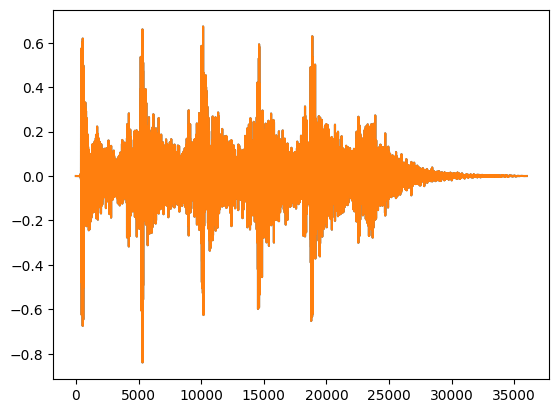

In [212]:
# Gun Shots
waveform6, sample_rate6 = plot_audio(file_path6)
plt.plot(waveform6) 
plt.show()

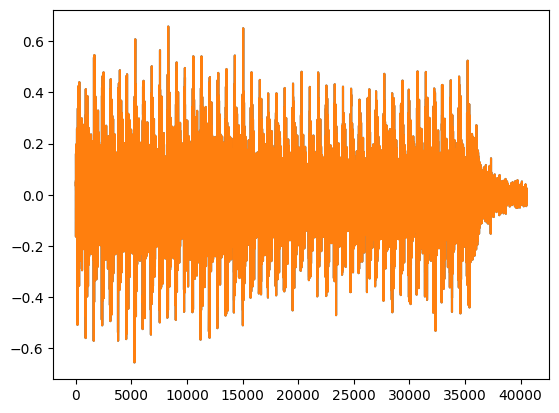

In [213]:
# Jackhammer
waveform7, sample_rate7 = plot_audio(file_path7)
plt.plot(waveform7) 
plt.show()

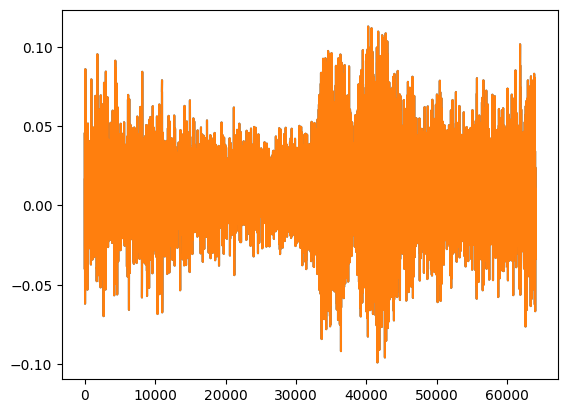

In [214]:
# Siren
waveform8, sample_rate8 = plot_audio(file_path8)
plt.plot(waveform8) 
plt.show()

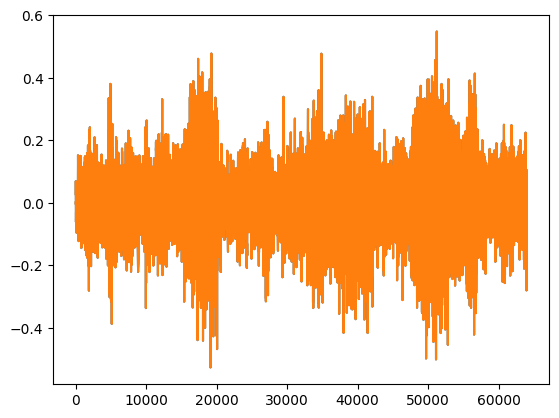

In [215]:
# Street Music
waveform9, sample_rate9 = plot_audio(file_path9)
plt.plot(waveform9) 
plt.show()

As you can see and hear (in the corresponding presentation), some of the sounds are similar...for example Air Conditioner and Engine Idling.

In [345]:
def plot_histograms_by_category(df, value_col, category_col):
    """
    Plots histograms for the distribution of values in 'value_col',
    split by categories in 'category_col'.

    Args:
        df (pd.DataFrame): The DataFrame.
        value_col (str): Column with the values for histograms.
        category_col (str): Column with categories to split by.
    """
    for category in df[category_col].unique():
        subset_df = df[df[category_col] == category]
        plt.hist(subset_df[value_col], label=category, alpha=0.7)

    plt.xlabel(value_col)
    plt.xticks(rotation='vertical')
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {category_col} by {value_col}")
    plt.legend(title=category_col)
    plt.show()

Now the metadata of the dataset will be explored for patterns/correlation and further insights:

In [348]:
# Load Data
# Path to UrbanSound8K metadata file
metadata_path = "./UrbanSound8K/metadata/UrbanSound8K.csv"

# Load CSV into a Pandas DataFrame
df = pd.read_csv(metadata_path)

# Define the base directory where audio files are stored
base_audio_path = "UrbanSound8K/audio/"

# Add full file paths to the DataFrame
df["file_path"] = df.apply(lambda row: os.path.join(base_audio_path, f"fold{row['fold']}", row['slice_file_name']), axis=1)

#create column with length of each clip
df["clip_length"] = df["end"]- df["start"]

#create column with length bins for correlation
bins = [-np.inf, .99, 1.99, 2.99, 3.99, np.inf]
labels = ['<1 sec', '1-1.99 sec', '2-2.99 sec', '3-3.99 sec', '4 sec']

df['length_bins'] = pd.cut(df['clip_length'], bins=bins, labels=labels)

# Show first few rows with full paths
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,file_path,clip_length,length_bins
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav,0.317551,<1 sec
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav,4.000000,4 sec
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav,4.000000,4 sec
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav,4.000000,4 sec
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav,4.000000,4 sec


In [322]:
# count for each category
df['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Most classes contain 1000 samples, with less for gun_shot, car_horn, and siren.  Those are more distinct sounds, so perhaps less training is needed for those categories.

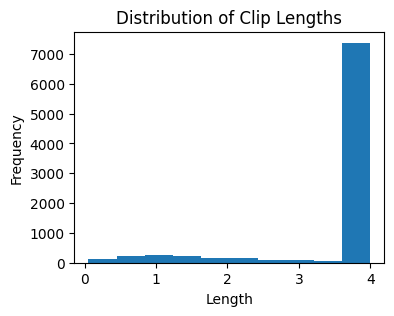

In [319]:
# distribution of clip length
plt.figure(figsize=(4, 3)) 
plt.hist(df['clip_length'], bins=10)
plt.title('Distribution of Clip Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

As you can see from the histogram, most clips are 4 seconds in length.  Those that aren't will be padded, so the  model uses the features of the sound to classify, not the clip lengths.

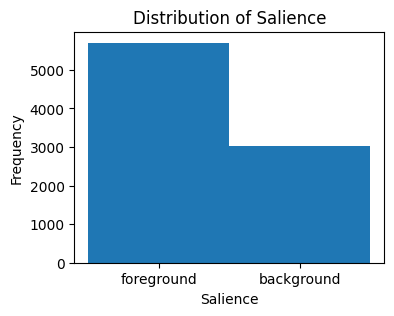

In [340]:
# distribution of salience
bin_edges = [0, 1.1, 2.2]
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
plt.figure(figsize=(4, 3)) 
plt.hist(df['salience'], bins=bin_edges)
plt.title('Distribution of Salience')
plt.xlabel('Salience')
plt.xticks(bin_centers, labels=['foreground', 'background'])
plt.ylabel('Frequency')
plt.show()

There are more clips with foreground noise than background, lets look at a breakdown of salience by category, as I'd expect that background noise is more difficult to classify.

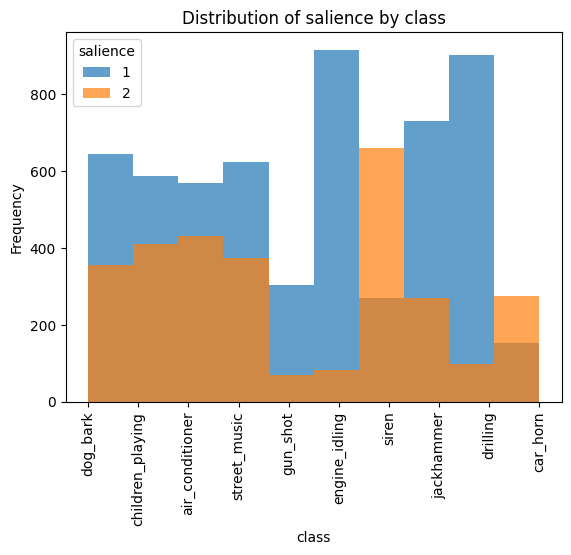

In [346]:
plot_histograms_by_category(df, 'class', 'salience')

car_horn and siren have have more clips labeled as background(2/orange), all the other classes are majority foreground (1/blue).

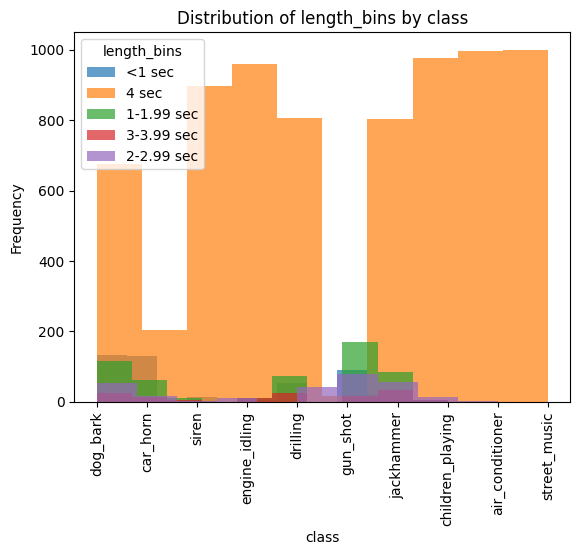

In [349]:
plot_histograms_by_category(df, 'class', 'length_bins')

The classes with short clips are dog_bark, car_horn, drilling, gun_shot, and jackhammer.  These clips will be padded in preprocessing, but less data may lead to worse model performance for these categories.

In [285]:
def create_dataset(df, validation_fold):
    """
    Splits the dataset into training and validation sets using the predefined fold column.
    """
    # Train = all folds except `validation_fold`
    train_df = df[df["fold"] != validation_fold]
    test_df = df[df["fold"] == validation_fold]

    # Extract file paths and labels
    train_files, train_labels = train_df["file_path"].values, train_df["classID"].values
    test_files, test_labels = test_df["file_path"].values, test_df["classID"].values

    # Convert to TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))

    return train_ds, test_ds

### Preprocessing Dataset
In my research I've read that preprossing has a big impact on CNN model performance when dealing with audio data.  I hope that by comparing different preprocessing techniques, I can better understand their impact on model performance. First I will write a function to visualize each spectrogram or feature representation.

In [264]:
def display_spectrogram(file_path, preprocess_fn, title="Spectrogram"):
    """Applies preprocessing function, ignores label output, and displays the spectrogram."""
    processed, _ = preprocess_fn(file_path, None)  # Ignore the label

    processed = processed.numpy() if tf.is_tensor(processed) else np.array(processed)

    plt.figure(figsize=(10, 4))

    if len(processed.shape) == 3:  # If shape is (250, 257, 1), squeeze the last dimension
        processed = np.squeeze(processed, axis=-1)

    if len(processed.shape) == 2:  # Spectrogram or MFCCs
        processed_db = librosa.power_to_db(processed, ref=np.max)  # Convert to dB scale
        librosa.display.specshow(processed_db, sr=16000, x_axis="time", y_axis="log")
        plt.colorbar(format="%+2.0f dB")
    
    elif len(processed.shape) == 1:  # Raw Waveform
        plt.plot(processed)
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency" if len(processed.shape) == 2 else "Amplitude")
    plt.show()

### Model Input Shapes Summary

| Preprocessing Method  | Expected Shape  | Suitable Model Type |
|----------------------|----------------|------------------|
| **Waveform** (Raw Audio) | `(64000, 1)` | 1D CNN, RNN (LSTM/GRU) |
| **Spectrogram** (STFT) | `(250, 257, 1)` | 2D CNN |
| **Log Mel Spectrogram** | `(250, 128, 1)` | 2D CNN |
| **MFCC** | `(250, 13, 1)` | 2D CNN |
| **MFCC + Delta** (MFCC + First & Second Derivatives) | `(250, 52, 1)` | 2D CNN |
| **CQT (Constant-Q Transform)** | `(250, 84, 1)` | 2D CNN |

#### **Additional Notes on Preprocessing Methods**
##### **1. MFCC + Delta Features**
- **Expected Shape:** `(time_frames, n_mfcc, 3)`, e.g., `(250, 52, 3)`
- **Why?**  
  - MFCCs capture static features of the sound.
  - First-order delta (Δ) represents change over time (velocity).
  - Second-order delta-delta (Δ²) represents acceleration.  
- **Best Model Type:** CNN (since it treats data like an image).

##### **2. Log Mel Spectrogram**
- **Expected Shape:** `(time_frames, n_mel_bins, 1)`, e.g., `(250, 128, 1)`
- **Why?**  
  - Mel filter banks are applied to the spectrogram and converted to log scale.
  - Closer to how human ears perceive sound.
- **Best Model Type:** CNN (like spectrograms).

##### **3. CQT (Constant-Q Transform)**
- **Expected Shape:** `(time_frames, n_frequency_bins, 1)`, e.g., `(250, 84, 1)`
- **Why?**  
  - Unlike STFT, **CQT uses logarithmically spaced frequency bins**, mimicking human hearing.
  - More useful for **music analysis and tonal sounds**.
- **Best Model Type:** CNN (like spectrograms).

#### **Choosing the Right Input Representation**
| Task | Recommended Preprocessing |
|------|---------------------------|
| Speech Recognition | MFCC / MFCC + Delta / Log Mel Spectrogram |
| Music Classification | CQT / Log Mel Spectrogram / Spectrogram |
| Environmental Sound Classification | Spectrogram / Log Mel Spectrogram / CQT |
| Speaker Identification | MFCC + Delta / Waveform |


Spectrogram Min: -0.413726806640625, Max: 0.434417724609375


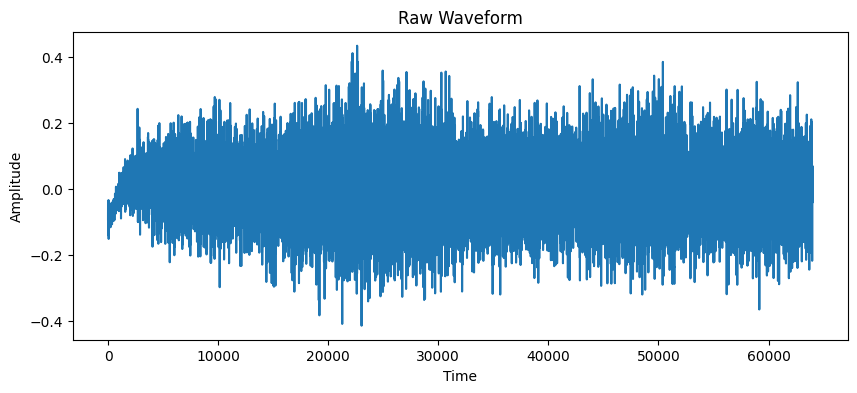

In [265]:
def preprocess_waveform(file_path, label):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
    return tf.squeeze(audio, axis=-1), label  # Remove the channel dimension

display_spectrogram(file_path0, preprocess_waveform, title="Raw Waveform")

Spectrogram Min: 0.00017458200454711914, Max: 20.313154220581055


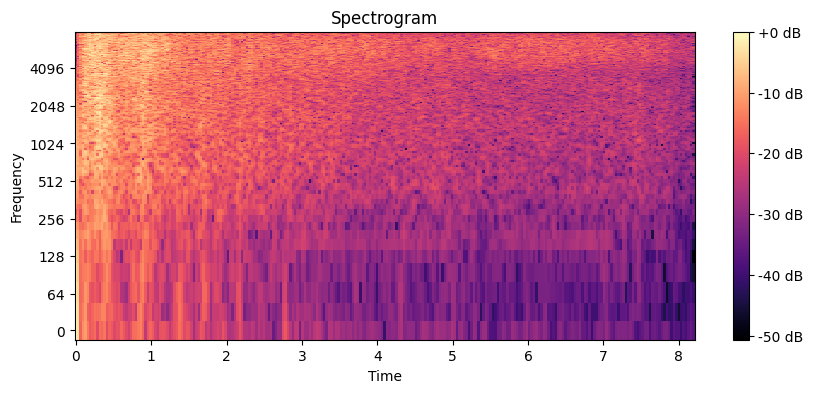

In [273]:
def preprocess_spectrogram(file_path, label):
    """Loads an audio file from a TensorFlow dataset, ensures a fixed length, and converts it to a spectrogram."""
    
    # Read and decode the WAV file
    audio = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio)
    audio = tf.squeeze(audio, axis=-1)  # Remove channel dimension if present

    # Ensure fixed length (4 sec = 64,000 samples at 16kHz)
    num_samples = 64000
    audio = audio[:num_samples]  # Trim if too long
    num_padding = tf.maximum(num_samples - tf.shape(audio)[0], 0)
    zero_padding = tf.zeros([num_padding], dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)  # Pad if too short

    # Compute spectrogram (STFT)
    spectrogram = tf.signal.stft(audio, frame_length=512, frame_step=128)
    spectrogram = tf.abs(spectrogram)  # Convert complex STFT to magnitude

    # Ensure fixed shape: (250, 257)
    spectrogram = spectrogram[:250, :257]  # Trim extra time steps and frequency bins
    spectrogram = tf.pad(spectrogram, [[0, 250 - tf.shape(spectrogram)[0]], 
                                       [0, 257 - tf.shape(spectrogram)[1]]])

    # Expand dimensions for CNN input
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram.set_shape((250, 257, 1))  # Explicitly set shape

    return spectrogram, label

display_spectrogram(file_path0, preprocess_spectrogram, title="Spectrogram")

Spectrogram Min: -3.9265711307525635, Max: 2.767991781234741


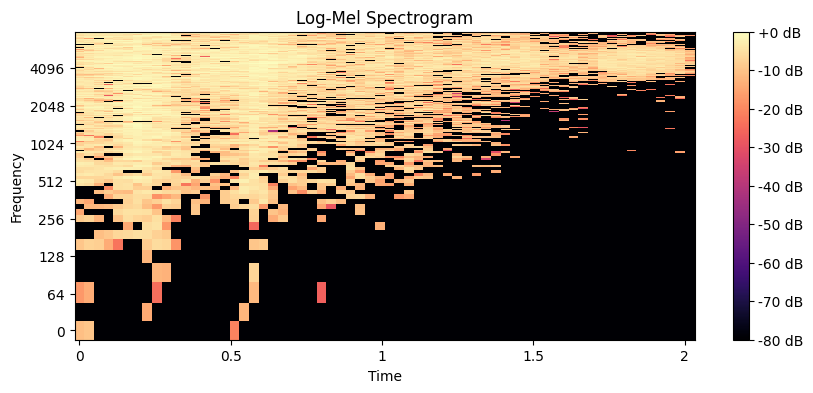

In [310]:
def preprocess_log_mel(file_path, label):
    """Preprocess audio file into log-mel spectrogram."""
    audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
    audio = tf.squeeze(audio, axis=-1)

    # Pad/trim to 4 seconds (64000 samples at 16kHz)
    num_samples = 64000
    audio = audio[:num_samples]
    zero_padding = tf.zeros([tf.maximum(0, num_samples - tf.shape(audio)[0])], dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)

    # Compute spectrogram
    stft = tf.signal.stft(audio, frame_length=400, frame_step=160)
    spectrogram = tf.abs(stft)  # Shape: (time, freq) ~ (398, 257)

    # Mel filterbank
    num_mel_bins = 64
    num_spectrogram_bins = stft.shape[-1]
    sample_rate = 16000

    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=sample_rate,
        lower_edge_hertz=80.0,
        upper_edge_hertz=sample_rate / 2.0,
    )

    mel_spectrogram = tf.tensordot(spectrogram, mel_weight_matrix, axes=1)
    mel_spectrogram.set_shape([None, num_mel_bins])  # Explicit shape for TF

    log_mel = tf.math.log(mel_spectrogram + 1e-6)  # Avoid log(0)

    # Trim/pad time dimension to fixed size (e.g., 250 time steps)
    desired_frames = 250
    log_mel = log_mel[:desired_frames, :]
    padding_frames = tf.maximum(0, desired_frames - tf.shape(log_mel)[0])
    log_mel = tf.pad(log_mel, [[0, padding_frames], [0, 0]])

    # Add channel dimension for CNNs
    log_mel = log_mel[..., tf.newaxis]  # Shape: (250, 64, 1)
    log_mel.set_shape((250, 64, 1))

    return log_mel, label

display_spectrogram(file_path0, preprocess_log_mel, title="Log-Mel Spectrogram")

Spectrogram Min: -19.272260665893555, Max: 10.852263450622559


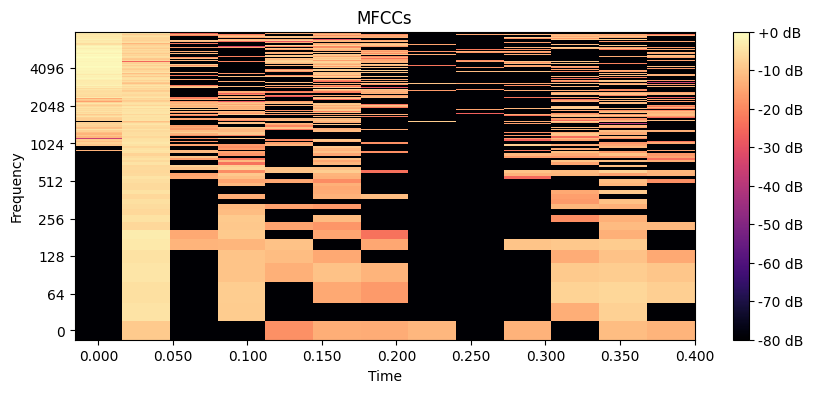

In [312]:
def preprocess_mfcc(file_path, label):
    """Loads an audio file, extracts MFCC features, and ensures a fixed shape."""
    
    def process(file_path):
        # Read and decode the WAV file
        audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
        audio = tf.squeeze(audio, axis=-1)  # Remove extra channel if present
        
        # Ensure fixed length (e.g., 4 sec @ 16kHz = 64000 samples)
        num_samples = 64000
        audio = audio[:num_samples]  # Trim if too long
        num_padding = tf.maximum(num_samples - tf.shape(audio)[0], 0)
        zero_padding = tf.zeros([num_padding], dtype=tf.float32)
        audio = tf.concat([audio, zero_padding], 0)  # Pad if too short
        
        # Compute STFT
        spectrogram = tf.signal.stft(audio, frame_length=400, frame_step=160)
        spectrogram = tf.abs(spectrogram)  # Convert STFT to magnitude

        # Compute Mel spectrogram
        mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=64, num_spectrogram_bins=257, sample_rate=16000
        )
        mel_spectrogram = tf.matmul(spectrogram, mel_weight_matrix)
        log_mel = tf.math.log(mel_spectrogram + 1e-6)

        # Compute MFCCs (13 coefficients)
        mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel)[:, :13]

        # Ensure fixed shape: (250 time frames, 13 MFCCs)
        desired_frames = 250
        mfcc = mfcc[:desired_frames, :]  # Trim extra frames
        pad_frames = tf.maximum(desired_frames - tf.shape(mfcc)[0], 0)
        mfcc = tf.pad(mfcc, [[0, pad_frames], [0, 0]])  # Pad if too short

        # Expand dims for CNN input (optional)
        mfcc = tf.expand_dims(mfcc, axis=-1)  # Shape: (250, 13, 1)

        # Set fixed shape for TensorFlow Graph
        mfcc.set_shape((250, 13, 1))

        return mfcc

    # Apply function using tf.py_function (needed for TensorFlow dataset pipeline)
    mfcc = tf.py_function(func=process, inp=[file_path], Tout=tf.float32)

    # Set static shape again (important for batching)
    mfcc.set_shape((250, 13, 1))

    return mfcc, label


display_spectrogram(file_path0, preprocess_mfcc, title="MFCCs")

Spectrogram Min: 0.000253017817158252, Max: 1.3002171516418457


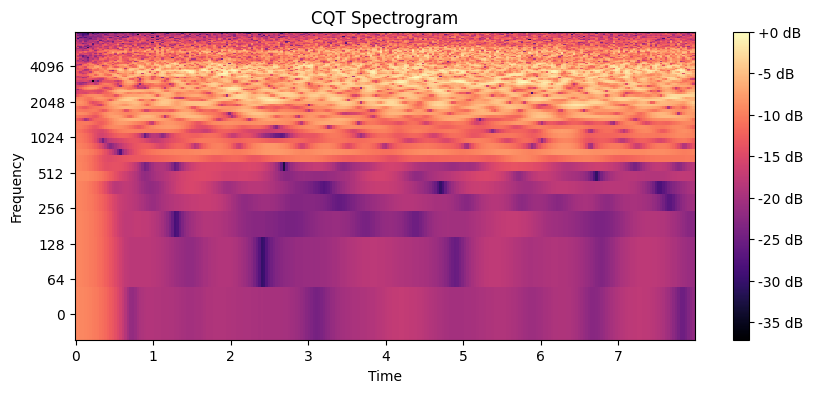

In [304]:
def preprocess_cqt(file_path, label):
    def process(file_path):
        import librosa
        import numpy as np

        path = file_path.numpy().decode("utf-8")
        audio, sr = librosa.load(path, sr=16000)

        # Ensure fixed length (4 seconds = 64000 samples)
        num_samples = 64000
        if len(audio) < num_samples:
            audio = np.pad(audio, (0, num_samples - len(audio)), mode='constant')
        else:
            audio = audio[:num_samples]

        # Compute CQT
        cqt = np.abs(librosa.cqt(audio, sr=sr, hop_length=160, n_bins=84))
        cqt = cqt[:, :250]  # Ensure consistent time shape

        # Pad if too short
        if cqt.shape[1] < 250:
            cqt = np.pad(cqt, ((0, 0), (0, 250 - cqt.shape[1])), mode='constant')

        cqt = np.expand_dims(cqt, axis=-1)
        return cqt.astype(np.float32)

    cqt_tensor = tf.py_function(func=process, inp=[file_path], Tout=tf.float32)
    cqt_tensor.set_shape((84, 250, 1))  # Fixed shape for CNN input

    return cqt_tensor, label

display_spectrogram(file_path0, preprocess_cqt, title="CQT Spectrogram")

(250, 52, 1)
Spectrogram Min: -17.42972183227539, Max: 74.4828872680664


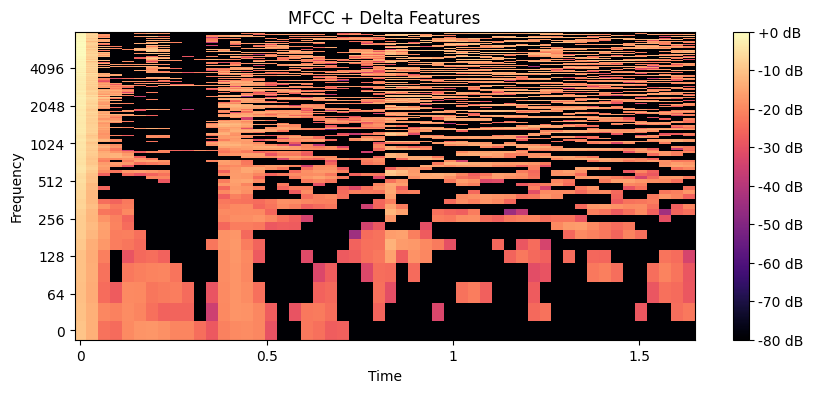

In [296]:
def preprocess_mfcc_delta(file_path, label):
    def process(file_path):
        file_path = file_path.numpy().decode("utf-8")
        audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
        audio = tf.squeeze(audio, axis=-1)  # Remove extra channel dim
        
        # Ensure fixed length (4 sec = 64,000 samples at 16kHz)
        num_samples = 64000
        audio = audio[:num_samples]  
        zero_padding = tf.zeros([num_samples - tf.shape(audio)[0]], dtype=tf.float32)
        audio = tf.concat([audio, zero_padding], 0)  

        # Compute Spectrogram → Mel Spectrogram → MFCC
        spectrogram = tf.signal.stft(audio, frame_length=512, frame_step=128)
        spectrogram = tf.abs(spectrogram)

        num_mel_bins = 26
        num_spectrogram_bins = 257
        sample_rate = 16000
        lower_edge_hertz = 20
        upper_edge_hertz = sample_rate / 2  

        mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz
        )

        mel_spectrogram = tf.matmul(spectrogram, mel_weight_matrix)
        mfcc = tf.signal.mfccs_from_log_mel_spectrograms(mel_spectrogram)[:, :num_mel_bins]

        # Compute delta features manually
        def compute_delta(mfcc):
            delta = mfcc[2:, :] - mfcc[:-2, :]
            delta = tf.pad(delta, [[1, 1], [0, 0]])  # Pad at beginning and end
            return delta

        mfcc_delta = compute_delta(mfcc)
        mfcc_combined = tf.concat([mfcc, mfcc_delta], axis=-1)  # Shape: (T, 26)

        # Ensure fixed shape
        mfcc_combined = mfcc_combined[:250, :]  
        mfcc_combined = tf.pad(mfcc_combined, [[0, tf.maximum(250 - tf.shape(mfcc_combined)[0], 0)], [0, 0]])

        return mfcc_combined

    # Wrap function for TensorFlow graph
    mfcc_delta = tf.py_function(func=process, inp=[file_path], Tout=tf.float32)

    # Set shape explicitly
    mfcc_delta.set_shape((250, 52))

    # Add channel dimension for CNN compatibility
    mfcc_delta = tf.expand_dims(mfcc_delta, axis=-1)  # Now (250, 52, 1)
    print(mfcc_delta.get_shape())
    return mfcc_delta, label

display_spectrogram(file_path0, preprocess_mfcc_delta, title="MFCC + Delta Features")


In [297]:
def create_model(input_shape=(250, 52, 1), num_classes=10):
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



Training on Fold 1 as validation set...
(250, 52, 1)
(250, 52, 1)
Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 195s 789ms/step - accuracy: 0.2509 - loss: 61.0103
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 189s 767ms/step - accuracy: 0.3475 - loss: 8.9207
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 188s 766ms/step - accuracy: 0.4890 - loss: 1.6549
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 186s 755ms/step - accuracy: 0.5593 - loss: 1.4572
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 186s 758ms/step - accuracy: 0.5295 - loss: 1.5252
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 187s 761ms/step - accuracy: 0.5875 - loss: 1.3103
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 188s 764ms/step - accuracy: 0.6045 - loss: 1.3301
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 189s 768ms/step - accuracy: 0.5789 - loss: 1.4675
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 190s 772ms/step - accuracy: 0.5999 - loss: 1.3651
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 190s 772ms/step - accuracy: 0.6241 - loss: 1.3256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms

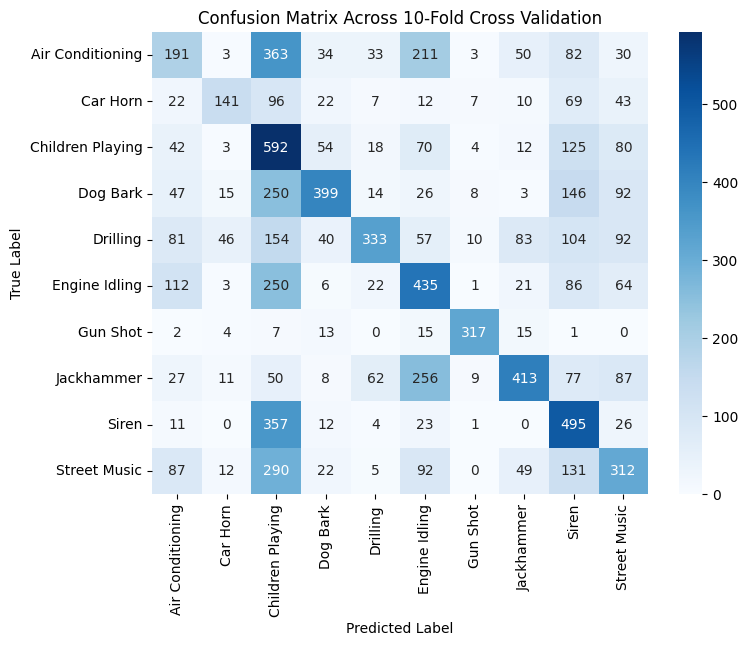

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.31      0.19      0.24      1000
        Car Horn       0.59      0.33      0.42       429
Children Playing       0.25      0.59      0.35      1000
        Dog Bark       0.65      0.40      0.50      1000
        Drilling       0.67      0.33      0.44      1000
   Engine Idling       0.36      0.43      0.40      1000
        Gun Shot       0.88      0.85      0.86       374
      Jackhammer       0.63      0.41      0.50      1000
           Siren       0.38      0.53      0.44       929
    Street Music       0.38      0.31      0.34      1000

        accuracy                           0.42      8732
       macro avg       0.51      0.44      0.45      8732
    weighted avg       0.48      0.42      0.42      8732



In [298]:
# class names for confusion matrix
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)
    
    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_mfcc_delta).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_mfcc_delta).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_model()

    # Train model
    model.fit(train_ds, epochs=10)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...
Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3096 - loss: 28.6182
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4618 - loss: 1.8260
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6142 - loss: 1.1478
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7016 - loss: 0.8820
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7527 - loss: 0.7717
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6765 - loss: 1.0431
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8186 - loss: 0.5837
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8612 - loss: 0.4460
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8770 - loss: 0.3874
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8949 - loss: 0.3417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

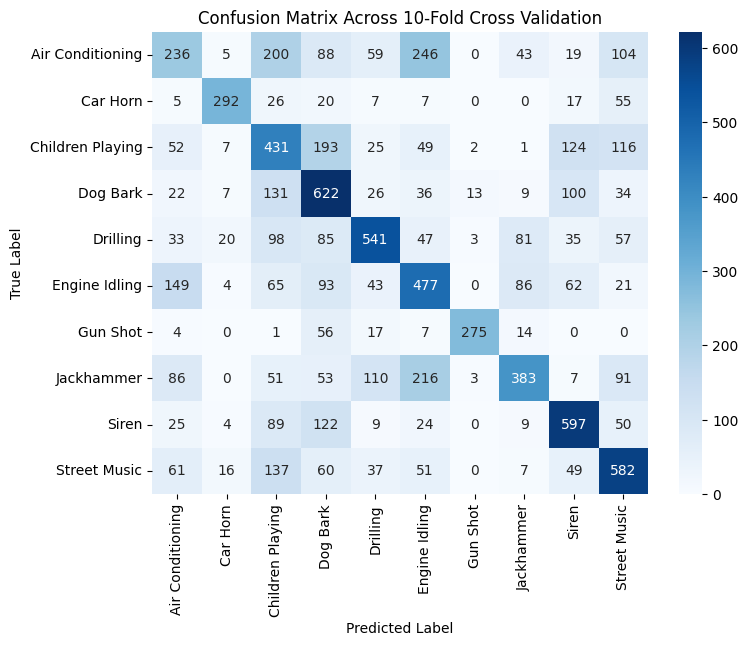

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.35      0.24      0.28      1000
        Car Horn       0.82      0.68      0.74       429
Children Playing       0.35      0.43      0.39      1000
        Dog Bark       0.45      0.62      0.52      1000
        Drilling       0.62      0.54      0.58      1000
   Engine Idling       0.41      0.48      0.44      1000
        Gun Shot       0.93      0.74      0.82       374
      Jackhammer       0.61      0.38      0.47      1000
           Siren       0.59      0.64      0.62       929
    Street Music       0.52      0.58      0.55      1000

        accuracy                           0.51      8732
       macro avg       0.57      0.53      0.54      8732
    weighted avg       0.52      0.51      0.51      8732



In [299]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_model(input_shape=(250, 257, 1))

    # Train model
    model.fit(train_ds, epochs=10)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...
Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 98s 396ms/step - accuracy: 0.2772 - loss: 2.7899
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 98s 397ms/step - accuracy: 0.3689 - loss: 1.7948
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 98s 398ms/step - accuracy: 0.5287 - loss: 1.3911
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 99s 402ms/step - accuracy: 0.6296 - loss: 1.1873
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 97s 392ms/step - accuracy: 0.6626 - loss: 1.0725
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 95s 387ms/step - accuracy: 0.7040 - loss: 0.9541
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 106s 432ms/step - accuracy: 0.7233 - loss: 0.8734
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 98s 397ms/step - accuracy: 0.7705 - loss: 0.7524
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 96s 391ms/step - accuracy: 0.7870 - loss: 0.7188
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 95s 387ms/step - accuracy: 0.8139 - loss: 0.6235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19

2025-04-04 09:23:15.566929: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


248/248 ━━━━━━━━━━━━━━━━━━━━ 99s 399ms/step - accuracy: 0.2425 - loss: 3.5909
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 99s 400ms/step - accuracy: 0.4039 - loss: 1.8304
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 99s 398ms/step - accuracy: 0.4995 - loss: 1.5406
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 99s 399ms/step - accuracy: 0.5963 - loss: 1.3235
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 98s 396ms/step - accuracy: 0.6079 - loss: 1.2157
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 98s 397ms/step - accuracy: 0.6529 - loss: 1.1180
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 99s 399ms/step - accuracy: 0.6727 - loss: 1.0088
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1066s 4s/step - accuracy: 0.7093 - loss: 0.9332
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1337s 5s/step - accuracy: 0.7165 - loss: 0.8570
Epoch 10/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 95s 381ms/step - accuracy: 0.7457 - loss: 0.7847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━

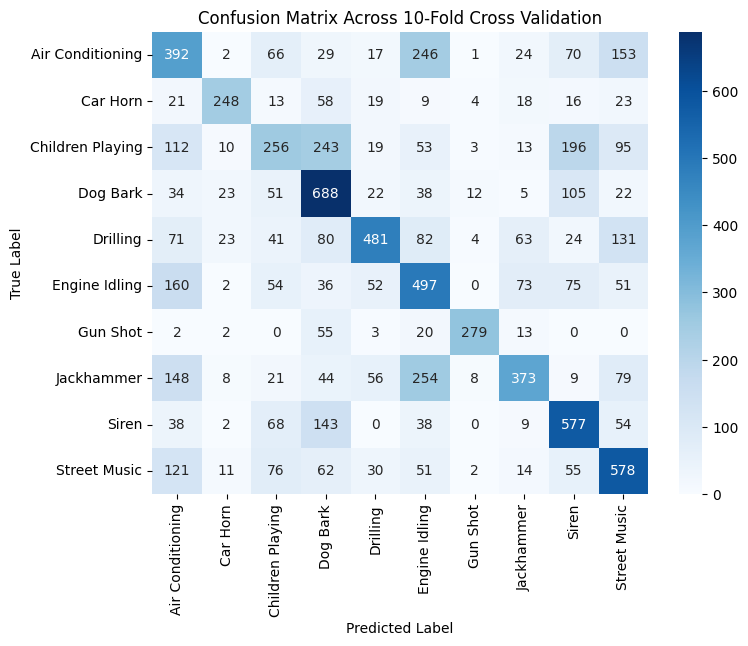

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.36      0.39      0.37      1000
        Car Horn       0.75      0.58      0.65       429
Children Playing       0.40      0.26      0.31      1000
        Dog Bark       0.48      0.69      0.56      1000
        Drilling       0.69      0.48      0.57      1000
   Engine Idling       0.39      0.50      0.43      1000
        Gun Shot       0.89      0.75      0.81       374
      Jackhammer       0.62      0.37      0.46      1000
           Siren       0.51      0.62      0.56       929
    Street Music       0.49      0.58      0.53      1000

        accuracy                           0.50      8732
       macro avg       0.56      0.52      0.53      8732
    weighted avg       0.52      0.50      0.50      8732



In [305]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_cqt).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_cqt).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_model(input_shape=(84, 250, 1))

    # Train model
    model.fit(train_ds, epochs=10)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...
Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2469 - loss: 17.3935
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5408 - loss: 1.7530
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5710 - loss: 1.2616
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6840 - loss: 1.0051
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7245 - loss: 0.9548
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7170 - loss: 0.8766
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8275 - loss: 0.6052
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8515 - loss: 0.5026
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8820 - loss: 0.4215
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9032 - loss: 0.3484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

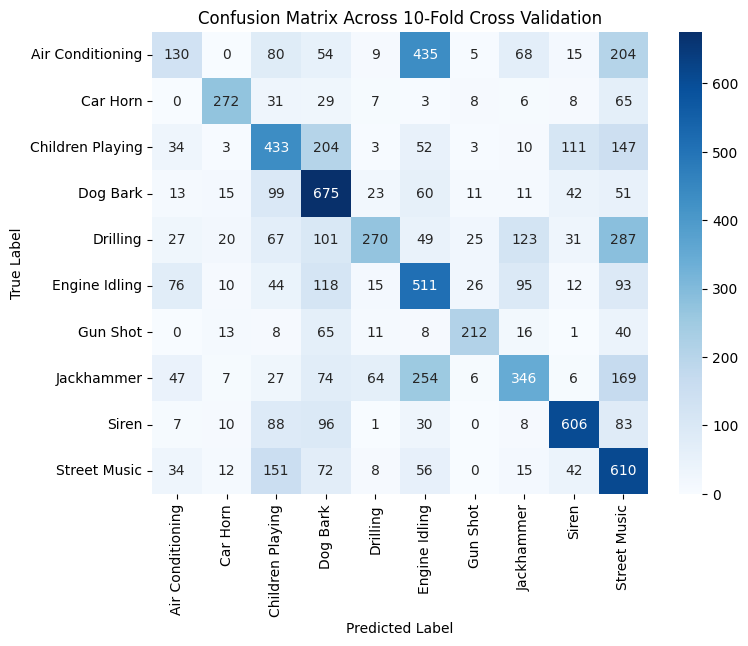

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.35      0.13      0.19      1000
        Car Horn       0.75      0.63      0.69       429
Children Playing       0.42      0.43      0.43      1000
        Dog Bark       0.45      0.68      0.54      1000
        Drilling       0.66      0.27      0.38      1000
   Engine Idling       0.35      0.51      0.42      1000
        Gun Shot       0.72      0.57      0.63       374
      Jackhammer       0.50      0.35      0.41      1000
           Siren       0.69      0.65      0.67       929
    Street Music       0.35      0.61      0.44      1000

        accuracy                           0.47      8732
       macro avg       0.52      0.48      0.48      8732
    weighted avg       0.49      0.47      0.45      8732



In [311]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_log_mel).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_log_mel).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_model(input_shape=(250, 64, 1))

    # Train model
    model.fit(train_ds, epochs=10)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...
Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 188s 761ms/step - accuracy: 0.2091 - loss: 8.0814
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 189s 767ms/step - accuracy: 0.4229 - loss: 1.6505
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 184s 749ms/step - accuracy: 0.5037 - loss: 1.3927
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.5386 - loss: 1.3142
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 188s 763ms/step - accuracy: 0.5839 - loss: 1.2412
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 189s 770ms/step - accuracy: 0.6132 - loss: 1.1610
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.6293 - loss: 1.0980
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 188s 766ms/step - accuracy: 0.6465 - loss: 1.0413
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 188s 765ms/step - accuracy: 0.6490 - loss: 1.0187
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 189s 769ms/step - accuracy: 0.7052 - loss: 0.8979
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

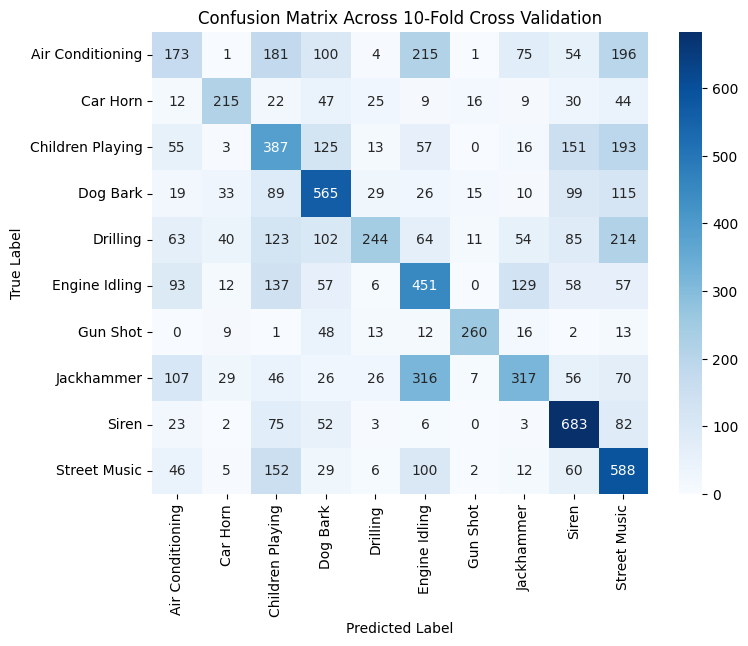

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.29      0.17      0.22      1000
        Car Horn       0.62      0.50      0.55       429
Children Playing       0.32      0.39      0.35      1000
        Dog Bark       0.49      0.56      0.53      1000
        Drilling       0.66      0.24      0.36      1000
   Engine Idling       0.36      0.45      0.40      1000
        Gun Shot       0.83      0.70      0.76       374
      Jackhammer       0.49      0.32      0.39      1000
           Siren       0.53      0.74      0.62       929
    Street Music       0.37      0.59      0.46      1000

        accuracy                           0.44      8732
       macro avg       0.50      0.47      0.46      8732
    weighted avg       0.47      0.44      0.43      8732



In [313]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)
    
    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_mfcc).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_mfcc).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_model((250,13,1))

    # Train model
    model.fit(train_ds, epochs=10)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

### Results using Simple Model

| Model | Run Time   | Accuracy |  
|----------|------------------|-------------|  
| Log Mel  | 5 min  | 47% |  
| STFT     | 14 min     | 51% |  
| CQT      | 4.5 hrs | 50% |  
| MFCC+Delta | 9.5 hrs      | 42% |  
| MFCC    | 10.25 hrs      | 44% | 

Since the Spectrogram (STFT) had the best accuracy on the simple model and a reasonable runtime, I will proceed with this preprocessing method and tune model to try to improve performance.  See tuning parameters in funciton below.  Depending on runtime I will tune some of these and possibly batch size and/or number of epochs.  This model tuning will be performed in a separate notebook, UrbanSoundModelTune.ipynb

In [361]:
def create_cnn_model(
    input_shape=(250, 257, 1),
    num_classes=10,
    num_conv_layers=3,
    conv_filters=[32, 64, 128],
    kernel_sizes=[(3, 3), (3, 3), (3, 3)],
    pool_sizes=[(2, 2), (2, 2), (2, 2)],
    dropout_rates=[0.25, 0.25, 0.5],
    dense_units=128,
    learning_rate=0.001,
    activation='relu',
    use_batch_norm=True
):
    """
    Create a CNN model for spectrogram classification with tunable hyperparameters.

    Parameters:
        input_shape (tuple): Shape of the input spectrogram (height, width, channels).
        num_classes (int): Number of output classes.
        num_conv_layers (int): Number of convolutional layers.
        conv_filters (list): Number of filters for each conv layer.
        kernel_sizes (list): Kernel size for each conv layer.
        pool_sizes (list): Pooling size after each conv layer.
        dropout_rates (list): Dropout rate after each pooling layer.
        dense_units (int): Number of units in the dense layer.
        learning_rate (float): Learning rate for the optimizer.
        activation (str): Activation function.
        use_batch_norm (bool): Whether to use batch normalization.

    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    
    model = tf.keras.models.Sequential()
    model.add(layers.Input(shape=input_shape))

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(conv_filters[i], kernel_sizes[i], padding='same', activation=None))
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.MaxPooling2D(pool_sizes[i]))
        model.add(layers.Dropout(dropout_rates[i]))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.Dropout(dropout_rates[-1]))
    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [362]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model()

    # Train model
    model.fit(train_ds, epochs=10)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...
Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.1732 - loss: 241.0140
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.2106 - loss: 197.0876
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.2810 - loss: 171.7120
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.3030 - loss: 140.0896
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.3204 - loss: 122.1450
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3391 - loss: 105.1256
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3478 - loss: 90.0295
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3884 - loss: 70.3783
Epoch 9/10
 17/246 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.4263 - loss: 70.7432

KeyboardInterrupt: 

### Preprocessing Conclusions/Key Learnings
- I learned about the digitization of audio, about sample rate, and that the amplitude of the wav curve is volume and the frequency is pitch.
- Not included in the notebook, I used ffmpeg to convert all the audio files to pcm_s16le to make the rest of preprocessing more uniform and go smoother.
- I tried many different preprocessing techniques, researched their strengths/weaknesses and experienced first hand their performance both speed and accuracy.
- As expected, background noises (like AC) were more difficult to classify.

Ideas from these articles/sites were used when creating the model:
- https://medium.com/@praveenachenthooran/building-an-audio-classification-model-with-tensorflow-6b3a3413e6b
- https://mikesmales.medium.com/sound-classification-using-deep-learning-8bc2aa1990b7
- https://learn.microsoft.com/en-us/training/modules/intro-audio-classification-tensorflow/
- https://www.tensorflow.org/io/tutorials/audio


# Please see next notebook in GitHub for model tuning